<a href="https://colab.research.google.com/github/ReemJbily/Employee-Burn-Out/blob/main/employee_burn_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

In [2]:
!pip install mlflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import catboost as cb

import pickle

# Setup MLFLOW

In [4]:
import mlflow
import mlflow.sklearn
mlflow.set_experiment('Employee-Burn-Out-Project')

2024/08/08 11:19:36 INFO mlflow.tracking.fluent: Experiment with name 'Employee-Burn-Out-Project' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/Windows.10/Employee-Burn-Out/mlruns/762207744267153043', creation_time=1723105176559, experiment_id='762207744267153043', last_update_time=1723105176559, lifecycle_stage='active', name='Employee-Burn-Out-Project', tags={}>

# Read Data

In [23]:
train=pd.read_csv(r'C://Users//Windows.10//Employee-Burn-Out//data//train.csv')

# Analyze Data

In [8]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [ ]:
print('number of columns',len(train.columns))
print('columns are:',train.columns)

number of columns 9
columns are: Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [ ]:
train.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

# Preprocessing
**1. remove duplicates**

**2. drop Employee ID**

**3. rename columns**



In [24]:
train.drop_duplicates(inplace=True)

In [25]:
train=train.drop('Employee ID',axis=1)

In [26]:
train['Mental Fatigue Score'].value_counts()

Mental Fatigue Score
6.0    470
5.8    464
5.9    458
6.1    457
6.3    454
      ... 
0.5     24
0.2     23
0.4     19
0.1     17
0.3     13
Name: count, Length: 101, dtype: int64

In [27]:
train.rename(columns={'WFH Setup Available': 'Remote','Resource Allocation':'Resource'}, inplace=True)

In [28]:
train.columns

Index(['Date of Joining', 'Gender', 'Company Type', 'Remote', 'Designation',
       'Resource', 'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [29]:
male=len(train[train['Gender']=='Male'])
female=len(train[train['Gender']=='Female'])
print('number of males:',male)
print('number of females:',female)

number of males: 10842
number of females: 11908


In [30]:
product=len(train[train['Company Type']=='Product'])
service=len(train[train['Company Type']=='Service'])
print('number of product companies:',product)
print('number of service companies:',service)

number of product companies: 7917
number of service companies: 14833


In [31]:
remote=len(train[train['Remote']=='Yes'])
onsite=len(train[train['Remote']=='No'])
print('number of remote companies:',remote)
print('number of onsite companies:',onsite)

number of remote companies: 12290
number of onsite companies: 10460


# Encoding
# **Categorical data:**
Date of Joining, Gender, Company Type, WFH Setup Available
# **Numerical data:**
Designation, Resource Allocation, Mental Fatigue Score, Burn Rate

In [32]:
train['Gender'] = train['Gender'].replace({'Male': 1,'Female': 0})
train['Company Type'] = train['Company Type'].replace({'Service': 1, 'Product': 0})
train['Remote'] = train['Remote'].replace({'Yes': 1, 'No': 0})

In [33]:
print(train['Date of Joining'].min(),'\n'+str(train['Date of Joining'].max()))

2008-01-01 
2008-12-31


In [34]:
#difference between the time employee arrived and the time of the survay which is 2020 kis 4 years
date=np.ones((len(train['Date of Joining']),1))
train['Work Period']=date*4

In [35]:
#no need for the date of joining column any more
train=train.drop('Date of Joining',axis=1)

# Handle missing data

In [36]:
mfs=train['Mental Fatigue Score'].isna().sum()/len(train['Mental Fatigue Score'])*100
res=train['Resource'].isna().sum()/len(train['Resource'])*100
br=train['Resource'].isna().sum()/len(train['Burn Rate'])*100


print('mental fatigue score null values percent is : '+str(mfs)+' %')
print('resource null values percent is : '+str(res)+' %')
print('Burn Rate null values percent is : '+str(br)+' %')

mental fatigue score null values percent is : 9.305494505494504 %
resource null values percent is : 6.07032967032967 %
Burn Rate null values percent is : 6.07032967032967 %


In [37]:
train.dropna(inplace=True)

# **Data Visulaization**

# not automated

C:\Users\Windows.10\AppData\Local\Temp\ipykernel_5704\3601930032.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


[Text(0, 0, 'Designation'),
 Text(1, 0, 'Resource'),
 Text(2, 0, 'Mental Fatigue Score')]

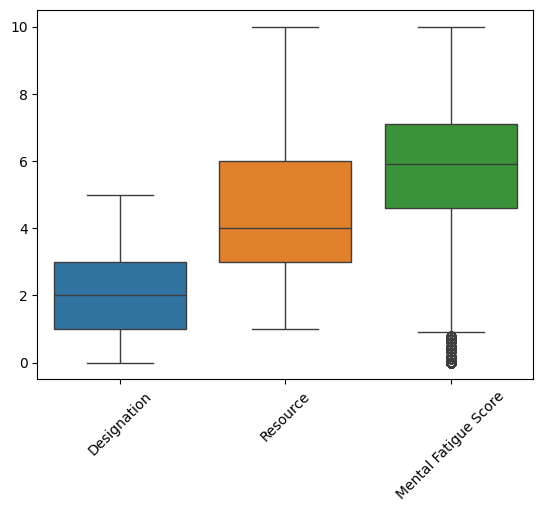

In [18]:
ax=sns.boxplot([train['Designation'],train['Resource'],train['Mental Fatigue Score']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<Axes: >

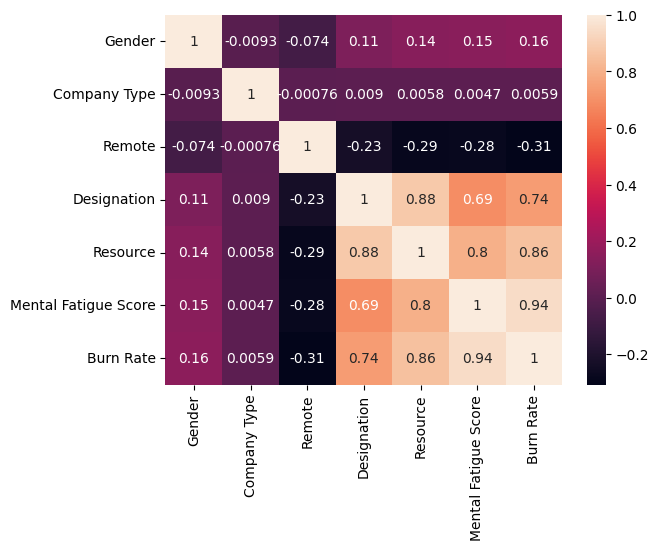

In [19]:
sns.heatmap(train.drop('Work Period',axis=1).corr(), annot=True)

Text(0.5, 1.0, 'remote/burn out rate')

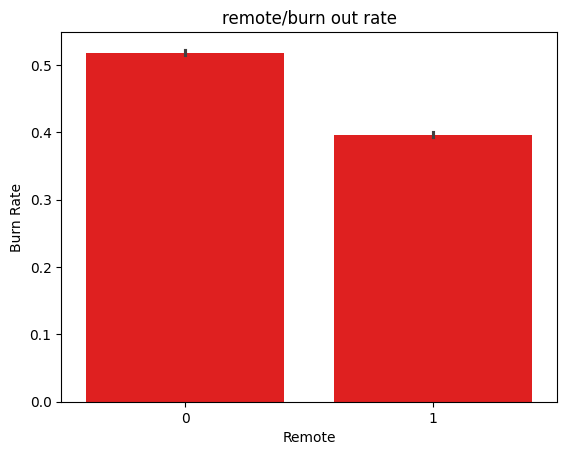

In [20]:
sns.barplot(data=train,x='Remote',y='Burn Rate',color='red')
plt.title('remote/burn out rate')

In [ ]:
#burn out is reduced with remote jobs

<Axes: xlabel='Designation', ylabel='Burn Rate'>

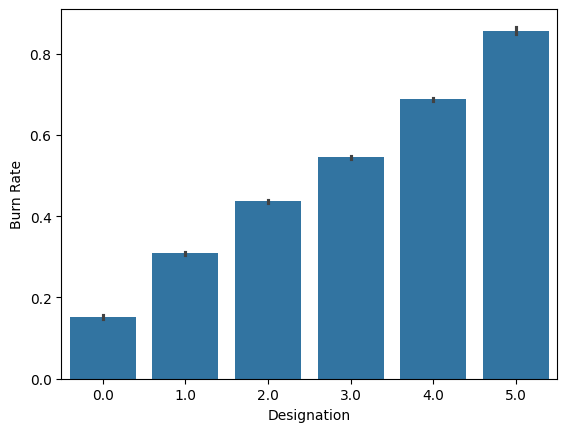

In [17]:
sns.barplot(data=train,x='Designation',y='Burn Rate')

In [ ]:
#burn out rate increases with seniority

<Axes: xlabel='Resource', ylabel='Burn Rate'>

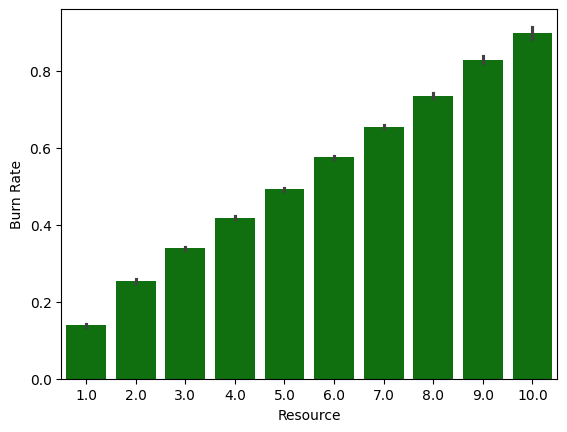

In [30]:
sns.barplot(data=train,x='Resource',y='Burn Rate',color='green')

In [ ]:
#employee having more resources means more burn out rate

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Mental Fatigue Score', ylabel='Burn Rate'>

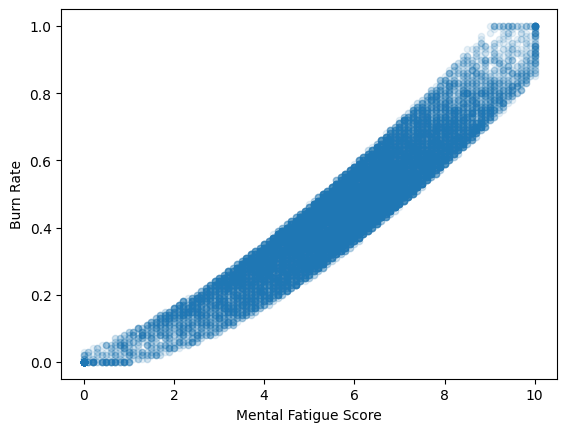

In [27]:
train.plot(kind="scatter", x="Mental Fatigue Score", y="Burn Rate", cmap="jet",
legend=True, sharex=False, alpha=0.1)

In [ ]:
#relationship between burn out rate and mental fatigue score is almost linear meaning the burn out increses when mental fatigue increates

<Axes: xlabel='Gender', ylabel='Resource'>

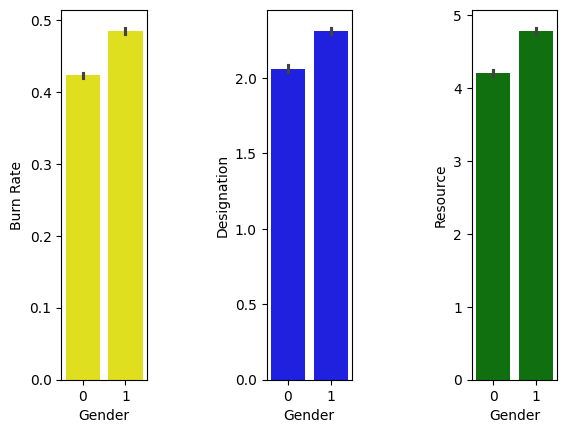

In [41]:
plt.subplot(1,5,1)
sns.barplot(data=train,x='Gender',y='Burn Rate',color='yellow')
plt.subplot(1,5,3)
sns.barplot(data=train,x='Gender',y='Designation',color='blue')
plt.subplot(1,5,5)
sns.barplot(data=train,x='Gender',y='Resource',color='green')

In [ ]:
#males suffer more burn out but males also more seniority and more resources

<Axes: xlabel='Company Type', ylabel='Burn Rate'>

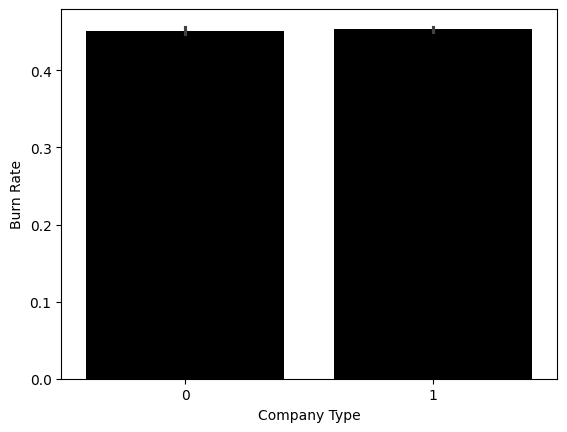

In [69]:
sns.barplot(data=train,x='Company Type',y='Burn Rate',color='black')

In [ ]:
#there is not much difference with the type of comapny

([<matplotlib.patches.Wedge at 0x237a2076c30>,
 [Text(0.08089020681418223, 1.0970217748256226, 'male'),
  Text(-0.08089020681418213, -1.0970217748256226, 'female')])

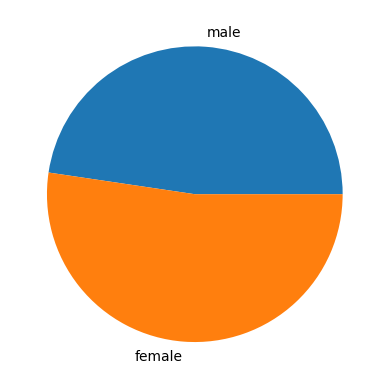

In [38]:
plt.pie(x=[male,female],labels=['male','female'])

([<matplotlib.patches.Wedge at 0x237a2107710>,
 [Text(-0.1386200531985119, 1.0912307184327437, 'Remote'),
  Text(0.138620053198512, -1.0912307184327437, 'Onsite')])

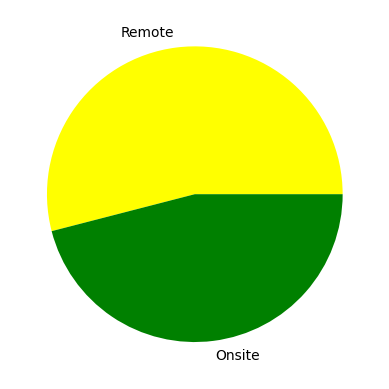

In [40]:
plt.pie(x=[remote,onsite],labels=['Remote','Onsite'],colors=['yellow','green'])

([<matplotlib.patches.Wedge at 0x2379fe4cf20>,
 [Text(0.5055378774171093, 0.9769500777913905, 'Product'),
  Text(-0.505537877417109, -0.9769500777913906, 'Service')])

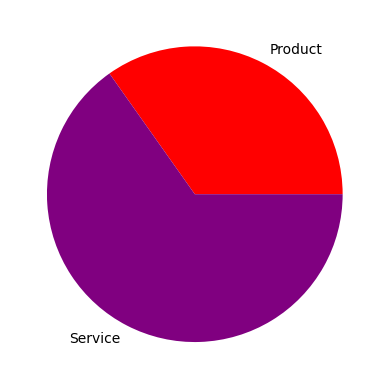

In [39]:
plt.pie(x=[product,service],labels=['Product','Service'],colors=['red','purple'])

# **Training**

In [41]:
X=train.drop('Burn Rate',axis=1)
Y=train['Burn Rate']

In [42]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [43]:
train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_test, y_test)

In [44]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [45]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03,0.5, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 0.4805746	test: 0.4749649	best: 0.4749649 (0)	total: 164ms	remaining: 16.2s
1:	learn: 0.4670032	test: 0.4615576	best: 0.4615576 (1)	total: 166ms	remaining: 8.14s
2:	learn: 0.4537694	test: 0.4485526	best: 0.4485526 (2)	total: 168ms	remaining: 5.44s
3:	learn: 0.4408435	test: 0.4357870	best: 0.4357870 (3)	total: 170ms	remaining: 4.08s
4:	learn: 0.4285646	test: 0.4236564	best: 0.4236564 (4)	total: 174ms	remaining: 3.31s
5:	learn: 0.4165150	test: 0.4117590	best: 0.4117590 (5)	total: 177ms	remaining: 2.77s
6:	learn: 0.4049369	test: 0.4002765	best: 0.4002765 (6)	total: 180ms	remaining: 2.38s
7:	learn: 0.3936840	test: 0.3891789	best: 0.3891789 (7)	total: 182ms	remaining: 2.09s
8:	learn: 0.3826957	test: 0.3783725	best: 0.3783725 (8)	total: 184ms	remaining: 1.86s
9:	learn: 0.3722001	test: 0.3680915	best: 0.3680915 (9)	total: 188ms	remaining: 1.69s
10:	learn: 0.3619576	test: 0.3580163	best: 0.3580163 (10)	total: 193ms	remaining: 1.56s
11:	learn: 0.3519707	test: 0.3481253	best: 0.3481253

{'params': {'depth': 6,
  'learning_rate': 0.5,
  'l2_leaf_reg': 1,
  'iterations': 100},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [46]:
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [47]:
rf= RandomForestRegressor(random_state=42)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

# Evaluation

In [48]:
from sklearn.model_selection import cross_val_score

In [49]:
def cross_validation(model,input_data=x_train,lable=y_train,scoring_='neg_root_mean_squared_error'):
  return -cross_val_score(model, input_data, lable,
                          scoring=scoring_)

In [50]:
linear_regression_rmse=cross_validation(lr)

In [22]:
linear_regression_rmse

array([0.05598158, 0.05610385, 0.05635451, 0.05560199, 0.05522109])

In [51]:
lr_pred=lr.predict(x_test)

# **mean square error**

# linear regression

In [24]:
mean_squared_error(y_test,lr_pred)

0.0030638579021906105

# random forest

In [25]:
mean_squared_error(y_test,rf.predict(x_test))

0.0033694226458284445

# catboost

In [26]:
mean_squared_error(y_test, model.predict(x_test))

0.0028064685464026127

# Save model

In [59]:
pickle.dump(model , open('burn-out-model.pk1' , 'wb'))

In [60]:
loaded_model = pickle.load(open('burn-out-model.pk1' , 'rb'))

# Burn out rate prediction

In [27]:
pred=model.predict(x_test)

In [62]:
x_test.head(1)

,Gender,Company Type,Remote,Designation,Resource,Mental Fatigue Score,Work Period
8815,1,1,1,1.0,2.0,3.9,4.0


In [70]:
print('employee',8815,'burn out rate is',round(pred[0]*100,2),'%')

employee 8815 burn out rate is 26.34 %


(array([132., 226., 426., 618., 793., 688., 463., 246.,  87.,  39.]),
 array([-0.271902  ,  9.75147565, 19.77485329, 29.79823093, 39.82160857,
        49.84498621, 59.86836386, 69.8917415 , 79.91511914, 89.93849678,
        99.96187443]),
 <BarContainer object of 10 artists>)

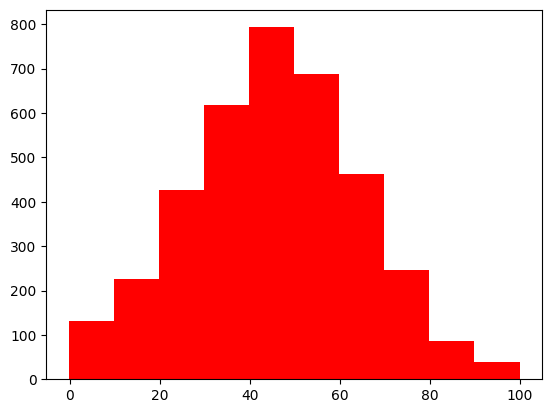

In [63]:
plt.hist(pred*100,color='red')

# Test the insights

In [31]:
import pytest
from unittest import TestCase

In [64]:
train['Resource'].value_counts()

Resource
4.0     3396
5.0     3364
3.0     2761
6.0     2590
2.0     1794
7.0     1697
1.0     1551
8.0      907
9.0      396
10.0     134
Name: count, dtype: int64

In [82]:
'''an employee:
1. is a male=1
2. the Company Type is service=1
3. work is not remote=0
4. Designation is high=4.0
5. have high resource=8
6. Mental Fatigue Score =8.0'''
gender=1
company_type=1
remote=0
designation=4.0
resource=8
mental_fatigue_score=8.0
work_period=4.0

data=[gender,company_type,remote,designation,resource,mental_fatigue_score,work_period]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 72.6 %


In [83]:
#for a female
data=[0,1,0,4.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 72.47 %


In [84]:
#remote work
data=[1,1,1,4.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 70.43 %


In [85]:
#remote work , designation low, resource high
data=[1,1,1,2.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 77.47 %


In [86]:
#female, remote work , designation low, resource high
data=[0,1,1,2.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 76.75 %


In [28]:
#female, remote work , designation low, resource low
data=[0,1,1,2.0,2.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 48.07 %


In [32]:
#female, remote work , designation low, resource low,low mental fatigue
data=[0,1,1,2.0,2.0,2.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 12.91 %


In [33]:
#female, remote work , designation low, resource low
data=[0,1,1,1.0,1.0,1.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 3.31 %


In [35]:
test_data=np.array([[1,1,0,4.0,8,8.0,4.0],[0,1,0,4.0,8.0,8.0,4.0],[1,1,1,4.0,8.0,8.0,4.0],
  [1,1,1,2.0,8.0,8.0,4.0],[0,1,1,2.0,8.0,8.0,4.0],[0,1,1,2.0,2.0,8.0,4.0],
  [0,1,1,2.0,2.0,2.0,4.0],[0,1,1,1.0,1.0,1.0,4.0]])

In [38]:
test=pd.DataFrame(test_data,columns=['Gender','Company Type','Remote','Designation','Resource','Mental Fatigue Score','Work Period'])

In [62]:
predictions=model.predict(test)

In [42]:
test['predictions']=predictions*100

In [58]:
test.head(8)

,Gender,Company Type,Remote,Designation,Resource,Mental Fatigue Score,Work Period,predictions
0,1.0,1.0,0.0,4.0,8.0,8.0,4.0,72.603221
1,0.0,1.0,0.0,4.0,8.0,8.0,4.0,72.471930
2,1.0,1.0,1.0,4.0,8.0,8.0,4.0,70.432557
3,1.0,1.0,1.0,2.0,8.0,8.0,4.0,77.472639
4,0.0,1.0,1.0,2.0,8.0,8.0,4.0,76.748176
5,0.0,1.0,1.0,2.0,2.0,8.0,4.0,48.071661
6,0.0,1.0,1.0,2.0,2.0,2.0,4.0,12.909549
7,0.0,1.0,1.0,1.0,1.0,1.0,4.0,3.313869
